<a href="https://colab.research.google.com/github/changhoonhahn/gqp_mc/blob/master/nb/validate_trained_desi_complexdust_speculator_wavebins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/speculator_fork

/content/drive/My Drive/speculator_fork


In [3]:
import os 
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from speculator import SpectrumPCA
from speculator import Speculator

In [4]:
# read DESI wavelength
wave = np.load('wave_fsps.npy')

In [5]:
wave_bin0 = (wave < 4500) 
wave_bin1 = (wave >= 4500) & (wave < 6500) 
wave_bin2 = (wave >= 6500) 
wave_bins = [wave_bin0, wave_bin1, wave_bin2]

In [17]:
n_param = 10
n_pcas  = [40, 30, 30]
N_trains = [int(2e6), int(5e6), int(5e6)]

In [18]:
speculators = [Speculator(restore=True, restore_filename='_DESI_complexdust_model.Ntrain%i.wave_bin%i.pca%i.log' % (N_train, n_wave, n_pcas[n_wave])) for n_wave, N_train in enumerate(N_trains)]

In [19]:
# read in training parameters and data
theta_test = np.load('DESI_complexdust.theta_test.npy')
_logspectrum_test = np.load('DESI_complexdust.logspectrum_fsps_test.npy')

logspectrum_test = []
for wave_bin in wave_bins: 
  logspectrum_test.append(_logspectrum_test[:,wave_bin])
logspectrum_test = np.concatenate(logspectrum_test, axis=1)
spectrum_test = 10**logspectrum_test

In [20]:
def combined_speculator(theta): 
  spectrum_spec = [] 
  for iwave in range(len(wave_bins)): 
    _logspectrum_spec = speculators[iwave].log_spectrum(theta)
    spectrum_spec.append(10**_logspectrum_spec)
  return np.concatenate(spectrum_spec, axis=1)

In [21]:
waves = []
for iwave in range(len(wave_bins)): 
  waves.append(wave[wave_bins[iwave]])
waves = np.concatenate(waves)

In [22]:
spectrum_spec = combined_speculator(theta_test.astype(np.float32))

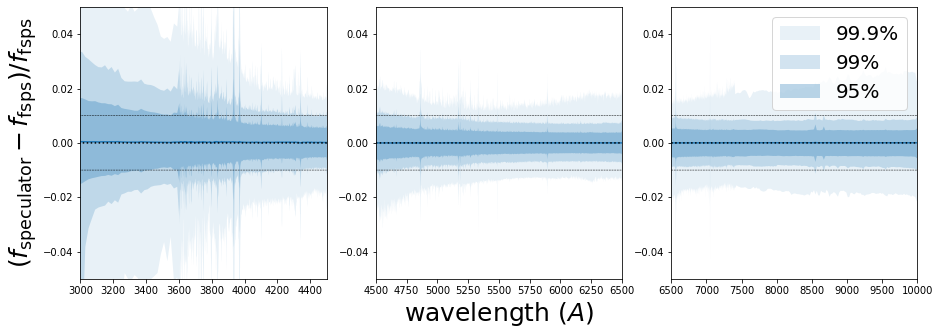

In [25]:
# more quantitative accuracy test of the Speculator model 
frac_dspectrum = (spectrum_spec - spectrum_test) / spectrum_test 
frac_dspectrum_quantiles = np.nanquantile(frac_dspectrum, 
        [0.0005, 0.005, 0.025, 0.5, 0.975, 0.995, 0.9995], axis=0)

fig = plt.figure(figsize=(15,5))
for iwave in range(len(wave_bins)): 
  sub = fig.add_subplot(1,3,iwave+1)
  sub.fill_between(waves, frac_dspectrum_quantiles[0],
          frac_dspectrum_quantiles[6], fc='C0', ec='none', alpha=0.1, label='99.9%')
  sub.fill_between(waves, frac_dspectrum_quantiles[1],
          frac_dspectrum_quantiles[5], fc='C0', ec='none', alpha=0.2, label='99%')
  sub.fill_between(waves, frac_dspectrum_quantiles[2],
          frac_dspectrum_quantiles[4], fc='C0', ec='none', alpha=0.3, label='95%')
  sub.plot(waves, frac_dspectrum_quantiles[3], c='C0', ls='-') 
  sub.plot(waves, np.zeros(len(waves)), c='k', ls=':') 
  sub.plot(waves, 0.01 * np.ones(len(waves)), c='k', ls='--', lw=0.5)
  sub.plot(waves, -0.01 * np.ones(len(waves)), c='k', ls='--', lw=0.5)
  if iwave == len(wave_bins) - 1: sub.legend(loc='upper right', fontsize=20)
  if iwave == 0: sub.set_xlim(3e3, 4.5e3)
  elif iwave == 1: 
    sub.set_xlabel('wavelength ($A$)', fontsize=25) 
    sub.set_xlim(4.5e3, 6.5e3)
  elif iwave == 2: sub.set_xlim(6.5e3, 1e4)
  if iwave == 0: sub.set_ylabel(r'$(f_{\rm speculator} - f_{\rm fsps})/f_{\rm fsps}$', fontsize=25) 
  sub.set_ylim(-0.05, 0.05) 
fig.savefig('validate_desi_complexdust.Ntrain%s.wave_bins.pca%s.png' % 
          ('_'.join([str(N_train) for N_train in N_trains]), '_'.join([str(n_pca) for n_pca in n_pcas])), bbox_inches='tight') 

(0.0, 1192.0)

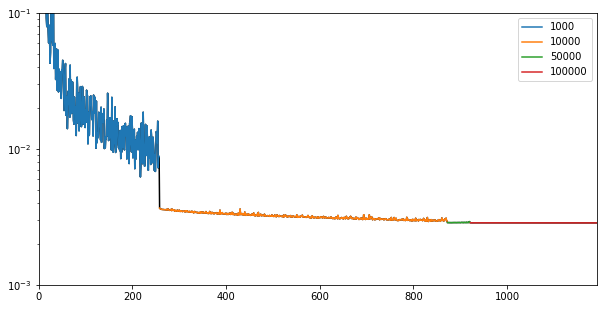

In [24]:
loss = np.loadtxt('DESI_complexdust_model.Ntrain%i.wave_bin%i.pca%i.loss.dat' % (N_trains[0], 0, n_pcas[0]))

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(np.arange(loss.shape[0]), loss[:,2], c='k')

for batchsize in np.unique(loss[:,0]):
  isbatch = (loss[:,0] == batchsize)
  sub.plot(np.arange(loss.shape[0])[isbatch], loss[:,2][isbatch], label='%i' % batchsize)
sub.legend(loc='upper right')
sub.set_yscale('log')
sub.set_ylim(1e-3, 0.1)
sub.set_xlim(0, loss.shape[0])